In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Dropping columns and splitting data into train and test

In [2]:
model_config = 'All' 
# model_config = 'Diff'

In [3]:
df = pd.read_csv('../data/final_data.csv')

metrics = ['FT{}G', '{}S', '{}ST', '{}Acc', '{}Conv']
team_metrics = ['{}Value', '{}CurrentPoints', '{}Rating']
refs = ['H', 'A']

stats_cols = [m.format(ref) for m, ref in [(m, r) for m in metrics for r in refs]]
team_cols = [m.format(ref) + '_5Avg' for m, ref in [(m, r) for m in metrics for r in refs]] + [m.format(ref) for m, ref in [(m, r) for m in team_metrics for r in refs]]
diff_cols = [m.format('') + '_5Avg_Diff' for m in metrics] + [m.format('') +'_Diff' for m in team_metrics]
other_cols = ['Season', 'Date', 'HomeTeam', 'AwayTeam']

dropped_columns = ['FTR'] + other_cols + stats_cols
if model_config == 'All':  dropped_columns += diff_cols
elif model_config == 'Diff': dropped_columns += team_cols 
    
df_train = df[df.Season <= '2017-2018']
df_train_x = df_train.drop(columns = dropped_columns)
df_train_y = df_train.FTR

df_test = df[df.Season == '2018-2019']
df_test_x = df_test.drop(columns = dropped_columns)
df_test_y = df_test.FTR

## Initialization

In [4]:
def evaluate(model, df_train_x, df_train_y, df_test_x, df_test_y):
    train_predictions = model.predict(df_train_x)
    train_accuracy = (train_predictions == df_train_y).mean()
    print('Training Accuracy = {:0.3f}%'.format(train_accuracy))
    test_predictions = model.predict(df_test_x)
    test_accuracy = (test_predictions == df_test_y).mean()
    print('Testing Accuracy = {:0.3f}%'.format(test_accuracy))
    
def join_pred_on_data(model, df_test):
    df_test_pred = df_test.copy()
    classes = model.classes_
    preds_proba = model.predict_proba(df_test_x)
    preds = model.predict(df_test_x)
    
    for i, cl in enumerate(classes):
        df_test_pred['PRED_{}'.format(cl)] = np.vectorize(lambda x: round(x, 3))(preds_proba[:, i])
    
    df_test_pred['PRED_RESULT'] = preds
    df_test_pred = df_test_pred[[x for x in df_test_pred.columns if x != 'FTR'] + ['FTR']]
        
    return df_test_pred

param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 70, 90],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [5, 7],
    'min_samples_split': [10, 12],
    'n_estimators': [20, 50, 500, 1500]
}


## Training model with Cross validation on training set

In [5]:
re_train = False

In [6]:
if model_config == 'All': model_file = '../saved_models/RF_all.sav'
elif model_config == 'Diff': model_file = '../saved_models/RF_diff.sav'

if re_train:
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)
    grid_search.fit(df_train_x, df_train_y)
    best_rf = grid_search.best_estimator_
    
else:
    best_rf = pickle.load(open(model_file, 'rb'))

## Assessing performance

In [7]:
evaluate(best_rf, df_train_x, df_train_y, df_test_x, df_test_y)

Training Accuracy = 0.768%
Testing Accuracy = 0.594%


In [8]:
# pickle.dump(best_rf, open(model_file, 'wb'))
df_test_pred = join_pred_on_data(best_rf, df_test)

## Building betting strategies

In [9]:
def get_res_1(row):
    result = row.FTR
    pred = row.PRED_RESULT
    bet_pred = row['BbAv{}'.format(pred)]
    
    if result == pred: res = bet_pred
    else: res = -1
    return res


threshold = 0.5
def get_res_2(row):
    result = row.FTR
    pred = row.PRED_RESULT
    prob = row['PRED_{}'.format(pred)]
    bet_pred = row['BbAv{}'.format(pred)]
    
    if prob > threshold:
        if result == pred: res = bet_pred
        else: res = -1
    else: res = 0
    return res
        
    
def get_res_3(row):
    result = row.FTR
    pred = row.PRED_RESULT
    prob = row['PRED_{}'.format(pred)]
    bet_pred = row['BbAv{}'.format(pred)]
    bet_prob = 1 / row['BbAv{}'.format(pred)]
    
    if prob > bet_prob:
        if result == pred: res = bet_pred
        else: res = -1
    else: res = 0
    return res
        

df_test_pred['res_1'] = df_test_pred.apply(get_res_1, axis = 1)
df_test_pred['res_2'] = df_test_pred.apply(get_res_2, axis = 1)
df_test_pred['res_3'] = df_test_pred.apply(get_res_3, axis = 1)

In [10]:
print('Betting strat 1: {:0.3}'.format(df_test_pred.res_1.sum() / len(df_test_pred[df_test_pred.res_1 != 0])))
print('Betting strat 2: {:0.3}'.format(df_test_pred.res_2.sum() / len(df_test_pred[df_test_pred.res_2 != 0])))
print('Betting strat 3: {:0.3}'.format(df_test_pred.res_3.sum() / len(df_test_pred[df_test_pred.res_3 != 0])))
print('\n(Threshold was {} for betting strat 2)'.format(threshold))

Betting strat 1: 0.647
Betting strat 2: 0.76
Betting strat 3: 0.671

(Threshold was 0.5 for betting strat 2)


## Plotting ROI against threshold for betting strategy 2

In [11]:
def func(threshold):

    def get_res_2(row):
        result = row.FTR
        pred = row.PRED_RESULT
        prob = row['PRED_{}'.format(pred)]
        bet_pred = row['BbAv{}'.format(pred)]

        if prob > threshold:
            if result == pred: res = bet_pred
            else: res = -1
        else: res = 0
        return res

    df_test_pred['res_2'] = df_test_pred.apply(get_res_2, axis = 1)
    
    ret = df_test_pred.res_2.sum()
    count = len(df_test_pred[df_test_pred.res_2 != 0])
    
    return ret/count if count > 0 else np.nan

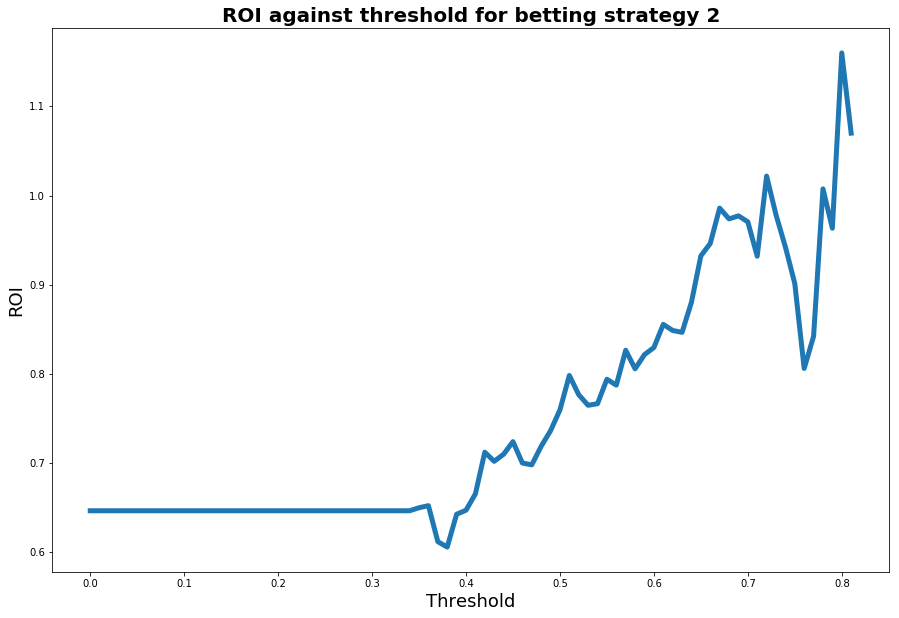

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x = [i / 100 for i in range(100)]
y = list(map(func, x))

plt.figure(figsize=(15, 10))
plt.xlabel('Threshold', fontsize = 18)
plt.ylabel('ROI', fontsize = 18)
plt.title('ROI against threshold for betting strategy 2', weight = 'bold', fontsize = 20)
plt.plot(x, y, linewidth = 5)
plt.show()